In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,max_error

In [75]:
class StaticModel(nn.Module):
    def __init__(self, input_dim_x, output_dim, hidden_sizes):
        super(StaticModel, self).__init__()
        # Define each layer separately
        self.input_layer = nn.Linear(input_dim_x, hidden_sizes[0])
        self.hidden_layer1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.output_layer = nn.Linear(hidden_sizes[1], output_dim)
        # Define activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass through the layers step by step
        out = self.input_layer(x)   # Input layer
        out = self.sigmoid(out)                     # Activation
        out = self.hidden_layer1(out)            # First hidden layer
        out = self.sigmoid(out)                     # Activation
        out = self.output_layer(out)             # Output layer
        out = self.sigmoid(out)
        return out

In [76]:
class SystemPredictor(nn.Module):
    def __init__(self, input_dim_x, input_dim_xn, output_dim, hidden_sizes=[64, 64]):
        super(SystemPredictor, self).__init__()
        total_input_dim = input_dim_x + input_dim_xn
        
        # Define each layer separately
        self.input_layer = nn.Linear(total_input_dim, hidden_sizes[0])
        self.hidden_layer1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.output_layer = nn.Linear(hidden_sizes[1], output_dim)

        # Define activation function
        self.tanh = nn.Tanh()

    def forward(self, x, xn):
        # Concatenate X (external inputs) and xn (previous state)
        combined_input = torch.cat([x, xn], dim=-1)

        # Pass through the layers step by step
        out = self.input_layer(combined_input)   # Input layer
        out = self.tanh(out)                     # Activation
        out = self.hidden_layer1(out)            # First hidden layer
        out = self.tanh(out)                     # Activation
        out = self.output_layer(out)             # Output layer
        
        return out

In [77]:
# Define RK4 integrator
class DynamicModel(nn.Module):
    def __init__(self, predictor, step_size):
        super(DynamicModel, self).__init__()
        self.predictor = predictor
        self.step_size = step_size  # Time step
        self.tanh = nn.Tanh()

    def forward(self, x, xn):
        h = self.step_size  # Time step size

        # Compute RK4 stages
        k1 = self.predictor(x, xn)
        k2 = self.predictor(x, xn + 0.5 * h * k1)
        k3 = self.predictor(x, xn + 0.5 * h * k2)
        k4 = self.predictor(x, xn + h * k3)

        # RK4 integration formula to compute the next state
        next_state = xn + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        next_state = self.tanh(next_state)

        return next_state

In [183]:
def prepare_dataset(df, input_cols, output_cols, nsim, prediction_horizon, batch_size):
    """
    Prepare dataset and DataLoader from DataFrame.

    :param df: DataFrame containing the input and output columns
    :param input_cols: List of column names for input features
    :param output_cols: List of column names for output targets
    :param nsteps: Number of time steps for each sequence
    :param batch_size: Batch size for DataLoader
    :return: DataLoader instance with data in tensor format
    """
    # Extract input and output data from DataFrame
    inputs = torch.tensor(df[input_cols].values, dtype=torch.float32)
    outputs = torch.tensor(df[output_cols].values, dtype=torch.float32)

    X = []
    Y = []

    # Calculate the number of sequences
    num_sequences = len(df) // nsim

    for i in range(num_sequences):
        # Truncate data to fit exact number of sequences
        input_sim = inputs[i*nsim : (i+1)*nsim]
        output_sim = outputs[i*nsim : (i+1)*nsim]
        
        for j in range(nsim-prediction_horizon):
            x = input_sim[j : j+prediction_horizon]
            y = output_sim[j : j+prediction_horizon]

            X.append(x)
            Y.append(y)

    X = torch.stack(X)
    Y = torch.stack(Y)
    print(X.shape, Y.shape)
    
    # Create dataset and DataLoader
    dataset = TensorDataset(X, Y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader


In [79]:
class Dynamicmodelloss:
    def __init__(self, weight_instantaneous=1.0, weight_tracking=1):
        self.weight_instantaneous = weight_instantaneous
        self.weight_tracking = weight_tracking
        self.total_tracking_loss = 0.0  # To accumulate tracking loss

    def __call__(self, instantaneous_loss):
        # Calculate the combined loss
        combined_loss = (self.weight_instantaneous * instantaneous_loss + self.weight_tracking * self.total_tracking_loss)

        # Update the total tracking loss
        self.total_tracking_loss += instantaneous_loss.item()

        return combined_loss

In [80]:
def inference(dynamicmodel, X, Y, nsim):
    """
    Perform inference on the complete dataset using the RK4 integrator model.
    
    :param rk4_integrator: The RK4 integrator model for predictions.
    :param X: Tensor of shape [num_samples, sequence_length, nx] containing input data.
    :param ny: Number of output dimensions.
    :return: Tensor of shape [num_samples, sequence_length, ny] containing predicted states.
    """
    dynamicmodel.eval()  # Set the model to evaluation mode
    
    # Initialize the state variable xn to zero
    #xn = torch.zeros(ny, dtype=torch.float32)
    xn = Y[0,:]
    
    all_predictions = []
    
    with torch.no_grad():  # Disable gradient computation
        for t in range(nsim):
            
            inputs = X[t, :]

            # Predict the next state
            predicted_state = dynamicmodel(inputs, xn)
            
            # Store the predicted state
            all_predictions.append(predicted_state)
            
            # Update state for the next time step
            xn = predicted_state
        
    # Stack predictions to form the complete output tensor
    all_predictions = torch.stack(all_predictions, dim=1)  # Shape: [num_samples, sequence_length, ny]
    
    return all_predictions


In [81]:
# Example test function to evaluate the model
def test_model(predictions , test_data):
    predictions = np.array(predictions).T
    test_data = np.array(test_data)
    mae = np.mean(np.abs(predictions - test_data))
    mse = np.mean((predictions - test_data) ** 2)

    return mae,mse


In [82]:
def normalize_column(df, column_list, col_min, col_max, normalized_range):
    """
    Normalizes a column of a dataframe to the range [-1, 1].

    Parameters:
        df (pd.DataFrame): The input dataframe.
        column_name (str): The name of the column to normalize.
        
    Returns:
        pd.DataFrame: DataFrame with normalized column in the range [-1, 1].
    """
    for column_name in column_list:
        if normalized_range == (0, 1):
            # Normalize the column to the range [0, 1]
            df[column_name] = (df[column_name] - col_min) / (col_max - col_min)
        elif normalized_range == (-1, 1):
            # Normalize the column to the range [0, 1]
            df[column_name] = (df[column_name] - col_min) / (col_max - col_min)
        
            # Scale to the new range [-1, 1]
            df[column_name] = df[column_name] * 2 - 1
        else:
            raise ValueError("normalized_range must be either (0, 1) or (-1, 1)")
        
    return df

In [83]:
def denormalize(normalized_array, original_min, original_max, normalized_range):
    """
    Denormalizes a normalized array from the range [-1, 1] or [0, 1] back to the original range 
    [original_min, original_max].

    Parameters:
        normalized_array (list or np.ndarray): Multidimensional array of normalized values.
        original_min (float): The original minimum value before normalization.
        original_max (float): The original maximum value before normalization.
        normalized_range (tuple): Range used for normalization, either (0, 1) or (-1, 1).

    Returns:
        np.ndarray: A denormalized array in the original range [original_min, original_max].
    """
    # Convert to a numpy array (if not already) for easy element-wise operations
    normalized_array = np.array(normalized_array)
    
    if normalized_range == (-1, 1):
        # Denormalize from [-1, 1]
        denormalized_array = ((normalized_array + 1) / 2) * (original_max - original_min) + original_min
    elif normalized_range == (0, 1):
        # Denormalize from [0, 1]
        denormalized_array = normalized_array * (original_max - original_min) + original_min
    else:
        raise ValueError("normalized_range must be either (0, 1) or (-1, 1)")

    return denormalized_array

In [84]:
def inference_sequential_training(dynamicdmodel, staticmodel, X, ny):
    """
    Perform inference on the complete dataset using the RK4 integrator model.
    
    :param rk4_integrator: The RK4 integrator model for predictions.
    :param X: Tensor of shape [num_samples, sequence_length, nx] containing input data.
    :param ny: Number of output dimensions.
    :return: Tensor of shape [num_samples, sequence_length, ny] containing predicted states.
    """
    dynamicdmodel.eval()  # Set the model to evaluation mode
    staticmodel.eval()
    sequence_length,num_samples = X.shape
    
    # Initialize the state variable xn to zero
    state = torch.zeros(1, ny, dtype=torch.float32)
    
    current_predictions = []
    torque_predictions = []
    
    with torch.no_grad():  # Disable gradient computation
        for t in range(sequence_length):
            voltage_x = X[t, :].unsqueeze(1).T
            speed_angle = X[t, 3:].unsqueeze(1).T

            predicted_current = dynamicdmodel(voltage_x, state)
            inputs = torch.cat([predicted_current ,speed_angle], dim=-1)
            predicted_torque = staticmodel(inputs)
            
            # Store the predicted state
            current_predictions.append(predicted_current)
            torque_predictions.append(predicted_torque)
            
            # Update state for the next time step
            state = predicted_current.detach()
        
    # Stack predictions to form the complete output tensor
    current_predictions = torch.stack(current_predictions, dim=1)  
    torque_predictions = torch.stack(torque_predictions, dim=1)
    
    return current_predictions, torque_predictions


In [85]:
def evaluation_metrics(label,predictions):
    error = {}
    mean_err = mean_absolute_error(label,predictions)
    error["Mean absolute error"] = mean_err
    print(f"Mean absolute error: {mean_err}")
    
    mean_sq_err = mean_squared_error(label,predictions)
    error["Mean squared error"] = mean_sq_err
    print(f"Mean squared error: {mean_sq_err}")
    
    mean_ab_per_err = mean_absolute_percentage_error(label,predictions)
    error["Mean absolute percentage error"] = mean_ab_per_err
    print(f"Mean absolute percentage error: {mean_ab_per_err}")
        
    max_err = max_error(label,predictions)
    error["Maximum error"] = max_err
    print(f"Maximum error: {max_err}")
    
    #return error

In [ ]:
def train_model(dynamicmodel, train_loader, X_val, Y_val, nsim, prediction_horizon, num_epochs, lr, early_stopping):
    dynamicmodel_optimizer = optim.Adam(dynamicmodel.parameters(), lr=lr)
    loss_mse = nn.MSELoss()  
    train_mseloss_list = []
    val_mseloss_list = []

    # Hyperparameters for early stopping
    patience = 10  # Number of epochs to wait for improvement
    min_delta = 0  # Minimum change to qualify as an improvement
    best_loss = float('inf')
    wait = 0  # Counter for epochs without improvement

    # Ensure data is float32
    dynamicmodel.to(torch.float32)

    try:
        for epoch in range(num_epochs):
            dynamicmodel.train()
            train_mseloss = 0
            
            # Process each batch
            for batch_x, batch_y in train_loader:
                batch_x = batch_x.to(torch.float32)
                batch_y = batch_y.to(torch.float32)

                batch_mseloss = 0
                loss_function = Dynamicmodelloss()
                state = batch_y[:, 0, :3]

                # Process each time step in the batch
                for t in range(prediction_horizon-1):
                    # Get current time step input
                    inputs = batch_x[:, t+1, :]
                    current_y = batch_y[:, t+1, :3]

                    # Predict the next state with RK4 integrator
                    predicted_state = dynamicmodel(inputs, state)
                
                    # Compute loss (MSE between predicted and true current values)
                    #mseloss = loss_mse(predicted_state, current_y)
                    mseloss = loss_mse(predicted_state, current_y)
                    loss = loss_function(mseloss)
                    batch_mseloss += mseloss.item()

                    # Update state for the next time step
                    state = predicted_state.detach()

                # Backward pass and optimization
                dynamicmodel_optimizer.zero_grad()
                loss.backward()
                dynamicmodel_optimizer.step()
                    
                train_mseloss += batch_mseloss/(prediction_horizon-1)
            
            train_mseloss_list.append(train_mseloss / len(train_loader))

            # Evaluate on dev set
            val_predictions = inference(dynamicmodel,X_val, Y_val[:, :-1], nsim)
            val_mae, val_mse = test_model(val_predictions, Y_val[:, :-1])
            val_mseloss_list.append(val_mse)

            print(f"Epoch {epoch + 1}/{num_epochs}, Train loss(MSE): {train_mseloss / len(train_loader):.6f}, Validation loss(MSE): {val_mse :.6f}")

            if early_stopping == True:
                # Check for early stopping condition
                if val_mse <= best_loss - min_delta:
                    best_loss = val_mse
                    wait = 0  # Reset the counter if improvement
                    #print("Validation loss improved, resetting patience counter.")
                else:
                    wait += 1
                    print(f"No improvement. Patience counter: {wait}")

                if wait >= patience:
                    print("Early stopping triggered.")
                    break

    except KeyboardInterrupt:
        return train_mseloss_list, val_mseloss_list
        
    return train_mseloss_list, val_mseloss_list


In [ ]:
def train_dynamicmodel(dynamicmodel, X_train, Y_train, X_val, Y_val, batch_size, nsim, prediction_horizon, num_epochs, lr, early_stopping, patience):
    optimizer = optim.Adam(dynamicmodel.parameters(), lr=lr)
    loss_mse = nn.MSELoss()  
    train_mseloss_list = []
    val_mseloss_list = []

    # Hyperparameters for early stopping
    patience = patience  # Number of epochs to wait for improvement
    best_loss = float('inf')
    wait = 0  # Counter for epochs without improvement

    # Ensure data is float32
    dynamicmodel.to(torch.float32)
    try:
        for epoch in range(num_epochs):
            dynamicmodel.train()
            train_mseloss = 0
            
            batch_x, batch_y = random_batch(X_train, Y_train, batch_size)
            
            prediction_horizon_loss = torch.tensor(0.0, requires_grad=True)
            state = batch_y[:, 0, :-1]

            # Process each time step in the batch
            for t in range(prediction_horizon-1):
                # Get current time step input
                inputs = batch_x[:, t+1, :]
                current_y = batch_y[:, t+1, :-1]

                # Predict the next state with RK4 integrator
                current_prediction = dynamicmodel(inputs, state)
            
                # Compute loss (MSE between predicted and true current values)
                loss = loss_mse(current_prediction, current_y)
                prediction_horizon_loss = prediction_horizon_loss + loss

                # Update state for the next time step
                state = current_prediction.detach()

            # Backward pass and optimization
            optimizer.zero_grad()
            prediction_horizon_loss.backward()
            optimizer.step()
                
            train_mseloss += prediction_horizon_loss.item()/(prediction_horizon)
            train_mseloss_list.append(train_mseloss)

            # Evaluate on dev set
            dynamicmodel.eval()
            val_mseloss = 0
            sim_loss = 0
            with torch.no_grad():
                state = Y_val[0, :-1]
                for t in range(nsim):
                    inputs = X_val[t, :]

                    # Predict the next state
                    current_prediction = dynamicmodel(inputs, state)
                    
                    loss = loss_mse(current_prediction, Y_val[t, :-1])
                    sim_loss += loss.item()

                    # Update state for the next time step
                    state = current_prediction

            val_mseloss = sim_loss/nsim
            val_mseloss_list.append(val_mseloss)

            print(f"Epoch {epoch + 1}/{num_epochs}, Train loss(MSE): {train_mseloss :.6f}, Validation loss(MSE): {val_mseloss :.6f}")

            if early_stopping == True:
                # Check for early stopping condition
                if val_mseloss < best_loss:
                    best_loss = val_mseloss
                    wait = 0  # Reset the counter if improvement
                    best_weights = copy.deepcopy(dynamicmodel.state_dict())
                else:
                    wait += 1
                    
                if wait >= patience:
                    print("Early stopping triggered.")
                    dynamicmodel.load_state_dict(best_weights)
                    break

    except KeyboardInterrupt:
        return train_mseloss_list, val_mseloss_list
        
    return train_mseloss_list, val_mseloss_list

def train_staticmodel(staticmodel, dataloader, epochs, lr):
    staticmodel_optimizer = optim.Adam(staticmodel.parameters(), lr=lr)
    loss_mse = nn.MSELoss()
    staticmodel_loss_list = []

    try:
        for epoch in range(epochs):
            staticmodel.train()
            batch_loss = 0
            for x, y in dataloader:
                y = y.unsqueeze(-1)
                torque_predictions = staticmodel(x)
                loss = loss_mse(torque_predictions, y)

                staticmodel_optimizer.zero_grad()
                loss.backward()
                staticmodel_optimizer.step()

                batch_loss =+ loss.item()
            train_loss = batch_loss/len(dataloader)
            staticmodel_loss_list.append(train_loss)

            print(f"Epoch {epoch + 1}/{epochs}, Static model MSE loss: {train_loss}")
    except KeyboardInterrupt:
        return staticmodel_loss_list
    
    return staticmodel_loss_list

In [87]:
# Define input dimensions
ts = 0.00025  # Time step for RK4 integrator
nsim = 40000
prediction_horizon = 500
nx = 6  # Number of external inputs (voltages) + harmonics + induced voltage
ny = 3  # Number of outputs (currents)
batch_size = 1024 # Mini-batch size
num_epochs = 1000  # Number of epochs for training
lr = 0.001
step_size = 50  
gamma = 0.995
early_stoping = False

In [184]:
train_data = pd.read_hdf('/Users/chiragangadi/Uni Siegen/WHB_IAS/02_Data/01_Training/train_dataset.h5', key='table')
train_data = train_data[:40000]
traindata_normalised = normalize_column(train_data,['VM9.V [V]', 'VM7.V [V]', 'VM8.V [V]'], -420, 420, (-1,1))
traindata_normalised = normalize_column(traindata_normalised,['Speed'], 7000, 9400, (0,1))
traindata_normalised = normalize_column(traindata_normalised,['i_a', 'i_b', 'i_c'], -400, 400, (-1,1))
traindata_normalised = normalize_column(traindata_normalised,['Moving1.Torque [NewtonMeter]'], 0, 150, (0,1))

train_loader = prepare_dataset(traindata_normalised,['VM9.V [V]', 'VM7.V [V]', 'VM8.V [V]','Speed','sin(Phi_el [])','cos(Phi_el [])'],['i_a', 'i_b', 'i_c','Moving1.Torque [NewtonMeter]'] , nsim, prediction_horizon, batch_size)

torch.Size([39500, 500, 6]) torch.Size([39500, 500, 4])


In [89]:
val_data = pd.read_hdf('/Users/chiragangadi/Uni Siegen/WHB_IAS/02_Data/01_Training/train_dataset.h5', key='table')
val_data = val_data[:40000]

valdata_normalised = normalize_column(val_data,['VM9.V [V]', 'VM7.V [V]', 'VM8.V [V]'], -420, 420, (-1,1))
valdata_normalised = normalize_column(valdata_normalised,['Speed'], 7000, 9400, (0,1))
valdata_normalised = normalize_column(valdata_normalised,['i_a', 'i_b', 'i_c'], -400, 400, (-1,1))
valdata_normalised = normalize_column(valdata_normalised,['Moving1.Torque [NewtonMeter]'], 0, 150, (0,1))

X_val = torch.tensor(valdata_normalised[['VM9.V [V]', 'VM7.V [V]', 'VM8.V [V]', 'Speed','sin(Phi_el [])','cos(Phi_el [])']].values, dtype=torch.float32)
Y_val = torch.tensor(valdata_normalised[['i_a', 'i_b', 'i_c','Moving1.Torque [NewtonMeter]']].values, dtype=torch.float32)

In [107]:
test_data = pd.read_hdf('/Users/chiragangadi/Uni Siegen/WHB_IAS/02_Data/01_Training/train_dataset.h5', key='table')
test_data = test_data[:40000]

X_test = torch.tensor(test_data[['VM9.V [V]', 'VM7.V [V]', 'VM8.V [V]', 'Speed','sin(Phi_el [])','cos(Phi_el [])']].values, dtype=torch.float32)
Y_test = torch.tensor(test_data[['i_a', 'i_b', 'i_c','Moving1.Torque [NewtonMeter]']].values, dtype=torch.float32)

testdata_normalised = normalize_column(test_data,['VM9.V [V]', 'VM7.V [V]', 'VM8.V [V]'], -420, 420, (-1,1))
testdata_normalised = normalize_column(testdata_normalised,['Speed'], 7000, 9400, (0,1))
testdata_normalised = normalize_column(testdata_normalised,['i_a', 'i_b', 'i_c'], -400, 400, (-1,1))
testdata_normalised = normalize_column(testdata_normalised,['Moving1.Torque [NewtonMeter]'], 0, 150, (0,1))

X_test_normalised = torch.tensor(testdata_normalised[['VM9.V [V]', 'VM7.V [V]', 'VM8.V [V]', 'Speed','sin(Phi_el [])','cos(Phi_el [])']].values, dtype=torch.float32)
Y_test_normalised = torch.tensor(testdata_normalised[['i_a', 'i_b', 'i_c','Moving1.Torque [NewtonMeter]']].values, dtype=torch.float32)


In [91]:
# Instantiate the neural network predictor
predictor = SystemPredictor(input_dim_x=nx, input_dim_xn=ny, output_dim=ny)

# Instantiate the RK4 integrator with the neural network
dynamicmodel = DynamicModel(predictor, step_size=ts)

staticmodel = StaticModel(6,1,[64,64])

# Train the model
train_mseloss_list, val_mseloss_list, staticmodel_loss_list = train_model(dynamicmodel, staticmodel, train_loader, X_val, Y_val, nsim, prediction_horizon, num_epochs, lr, gamma, early_stoping)

Epoch 1/1000, Train loss(MSE): 0.014988, Validation loss(MSE): 0.014709
Epoch 2/1000, Train loss(MSE): 0.008824, Validation loss(MSE): 0.007783
Epoch 3/1000, Train loss(MSE): 0.005670, Validation loss(MSE): 0.005438
Epoch 4/1000, Train loss(MSE): 0.004407, Validation loss(MSE): 0.004523
Epoch 5/1000, Train loss(MSE): 0.003806, Validation loss(MSE): 0.004063
Epoch 6/1000, Train loss(MSE): 0.003465, Validation loss(MSE): 0.003776
Epoch 7/1000, Train loss(MSE): 0.003232, Validation loss(MSE): 0.003557
Epoch 8/1000, Train loss(MSE): 0.003044, Validation loss(MSE): 0.003379
Epoch 9/1000, Train loss(MSE): 0.002893, Validation loss(MSE): 0.003245
Epoch 10/1000, Train loss(MSE): 0.002773, Validation loss(MSE): 0.003123
Epoch 11/1000, Train loss(MSE): 0.002667, Validation loss(MSE): 0.003012
Epoch 12/1000, Train loss(MSE): 0.002571, Validation loss(MSE): 0.002922
Epoch 13/1000, Train loss(MSE): 0.002486, Validation loss(MSE): 0.002839
Epoch 14/1000, Train loss(MSE): 0.002412, Validation loss(MS

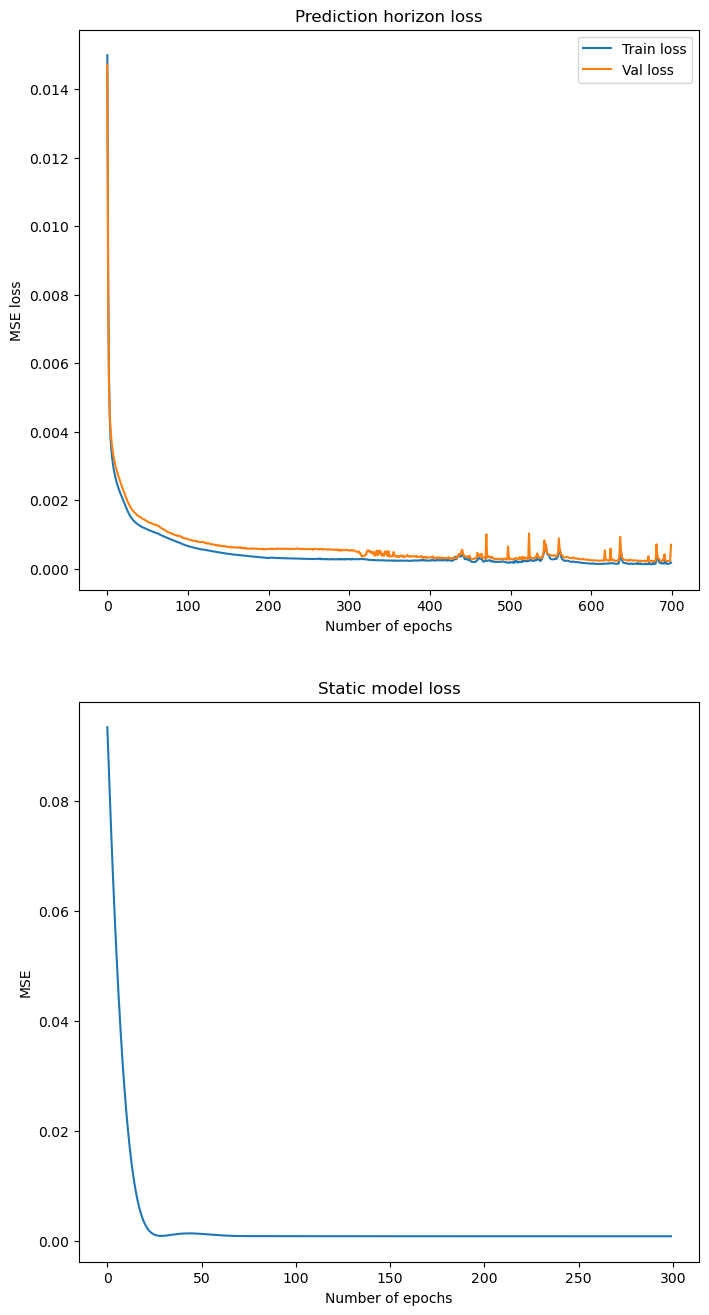

In [92]:
_, axs = plt.subplots(2,1,figsize=(8,16))
axs[0].plot(train_mseloss_list, label = "Train loss")
axs[0].plot(val_mseloss_list, label="Val loss")
axs[0].set_title("Prediction horizon loss")
axs[0].set_xlabel("Number of epochs")
axs[0].set_ylabel("MSE loss")
axs[0].legend()


axs[1].plot(staticmodel_loss_list)
axs[1].set_title("Static model loss")
axs[1].set_xlabel("Number of epochs")
axs[1].set_ylabel("MSE")

plt.show()

In [ ]:
current_predictions, torque_predictions = inference_sequential_training(dynamicmodel, staticmodel, X_test_normalised, ny)

In [149]:
current = current_predictions.squeeze()
speed_angle = X_val[:, 3:]

X = torch.concat([current,speed_angle], dim=1)
Y = Y_val[:,-1]

dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [157]:
epochs = 500
staticmodel = StaticModel(6,1,[64,64])

staticmodel_optimizer = optim.Adam(staticmodel.parameters(), lr=lr)
loss_mse = nn.MSELoss()
staticmodel_loss_list = []

In [158]:
for epoch in range(epochs):
    staticmodel.train()
    batch_loss = 0
    for x, y in dataloader:
        y = y.unsqueeze(-1)
        torque_predictions = staticmodel(x)
        loss = loss_mse(torque_predictions, y)

        staticmodel_optimizer.zero_grad()
        loss.backward()
        staticmodel_optimizer.step()

        batch_loss =+ loss.item()
    train_loss = batch_loss/len(dataloader)
    staticmodel_loss_list.append(train_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Static model MSE loss: {train_loss}")
    

Epoch 1/500, Static model MSE loss: 1.637575961649418e-06
Epoch 2/500, Static model MSE loss: 1.7053166404366493e-06
Epoch 3/500, Static model MSE loss: 1.5494155697524547e-06
Epoch 4/500, Static model MSE loss: 1.443586964160204e-06
Epoch 5/500, Static model MSE loss: 1.5727203339338303e-06
Epoch 6/500, Static model MSE loss: 1.8007032573223113e-06
Epoch 7/500, Static model MSE loss: 1.3896775431931019e-06
Epoch 8/500, Static model MSE loss: 9.318303316831589e-07
Epoch 9/500, Static model MSE loss: 1.838861033320427e-06
Epoch 10/500, Static model MSE loss: 1.5328765846788884e-06
Epoch 11/500, Static model MSE loss: 1.4135985635221004e-06
Epoch 12/500, Static model MSE loss: 1.5049527399241923e-06
Epoch 13/500, Static model MSE loss: 8.842203766107559e-07
Epoch 14/500, Static model MSE loss: 9.914898313581944e-07
Epoch 15/500, Static model MSE loss: 8.803938515484333e-07
Epoch 16/500, Static model MSE loss: 8.14433116465807e-07
Epoch 17/500, Static model MSE loss: 4.797924309968948e-07

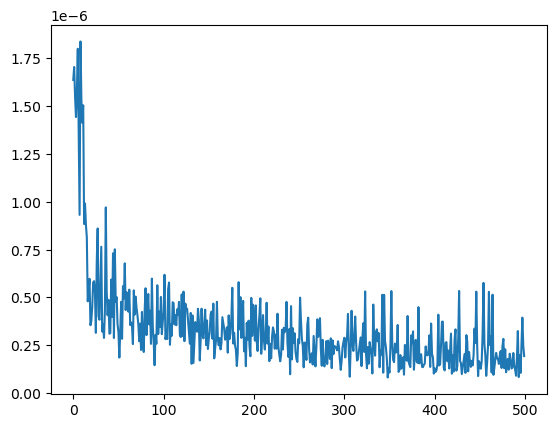

In [165]:
plt.plot(staticmodel_loss_list)

In [177]:
current_predictions, torque_predictions = inference_sequential_training(dynamicmodel, staticmodel, X_test_normalised, ny)

In [178]:
# Test the model
mae, mse = test_model(current_predictions,Y_test_normalised[:, :3])
print(f"Normalised data - Test error (MAE): {mae}, Test error (MSE): {mse}")

# current_predictions_normalised = inference(dynamicmodel, X_test_normalised_1, ny)
current_predictions = torch.tensor(denormalize(current_predictions, -400, 400,(-1,1)))
current_predictions = current_predictions.squeeze().T
torque_predictions = torch.tensor(denormalize(torque_predictions, 0, 150,(0,1)),dtype=torch.float32)
torque_predictions = torque_predictions.squeeze()
# Test the model
mae, mse = test_model(current_predictions,Y_test[:, :3])
print(f"Denormalised data - Test error (MAE): {mae}, Test error (MSE): {mse}")

Normalised data - Test error (MAE): 0.21149103343486786, Test error (MSE): 0.08143535256385803
Denormalised data - Test error (MAE): 5.039241790771484, Test error (MSE): 145.67579650878906


In [179]:
evaluation_metrics(Y_test[:, -1],torque_predictions)

Mean absolute error: 1.2010143995285034
Mean squared error: 3.1458709239959717
Mean absolute percentage error: 0.04014216735959053
Maximum error: 13.788167953491211


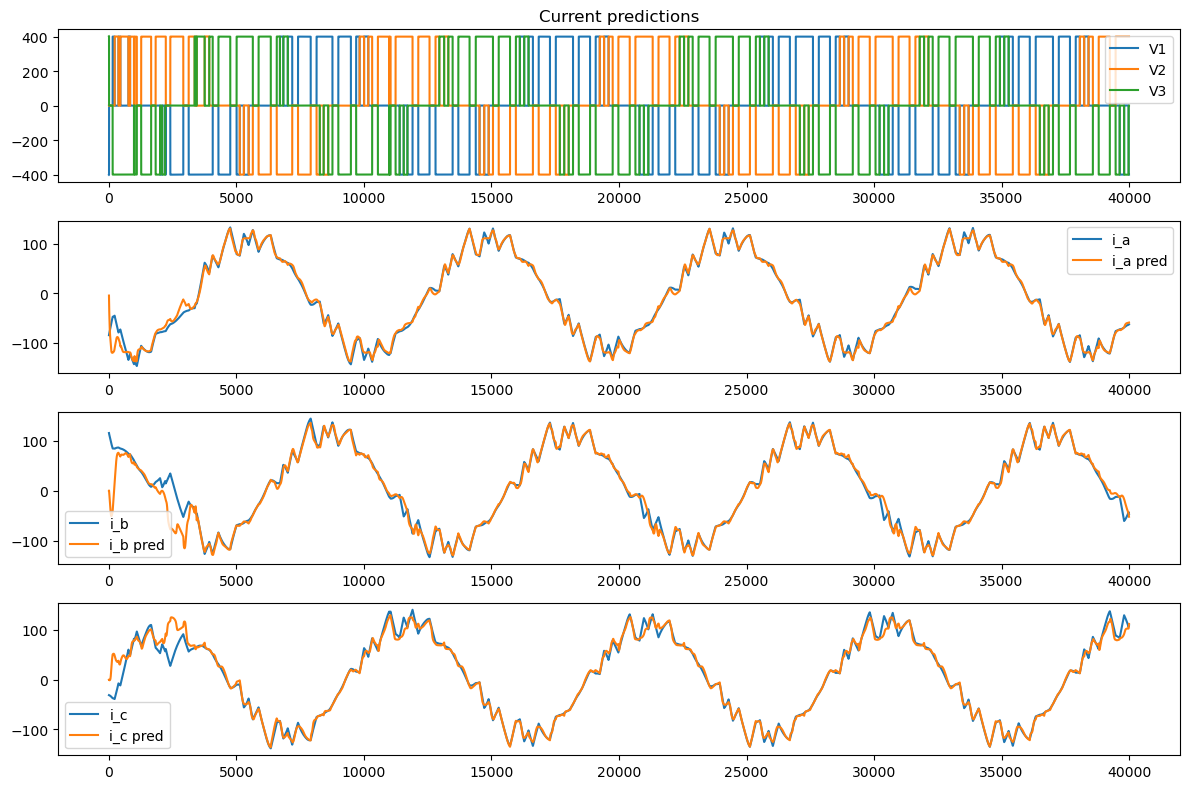

In [180]:
_, axs = plt.subplots(4,1, figsize=(12,8))

axs[0].plot(X_test[:,0], label = 'V1')
axs[0].plot(X_test[:,1], label = 'V2')
axs[0].plot(X_test[:,2], label = 'V3')
axs[0].set_title("Current predictions")
axs[0].legend()

axs[1].plot(Y_test[:,0], label = 'i_a')
axs[1].plot(current_predictions[0,:], label = 'i_a pred')
axs[1].legend()

axs[2].plot(Y_test[:,1], label = 'i_b')
axs[2].plot(current_predictions[1,:], label = 'i_b pred')
axs[2].legend()

axs[3].plot(Y_test[:,2], label = 'i_c')
axs[3].plot(current_predictions[2,:], label = 'i_c pred')
axs[3].legend()


plt.tight_layout()
plt.show()

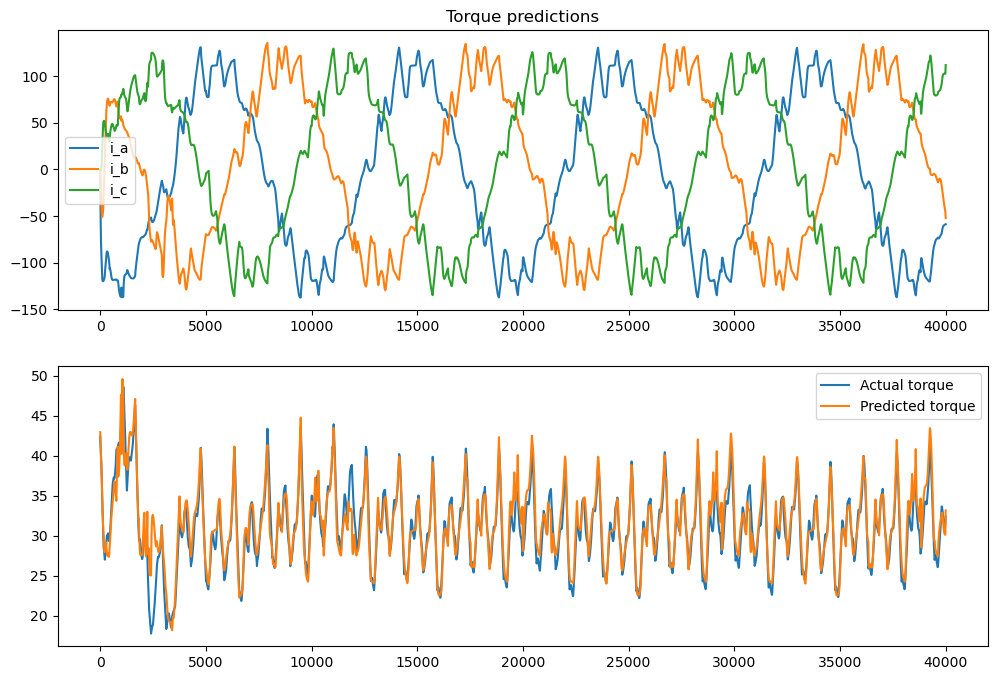

In [182]:
_, axs = plt.subplots(2,1, figsize=(12,8))

axs[0].plot(current_predictions[0,:], label = 'i_a')
axs[0].plot(current_predictions[1,:], label = 'i_b')
axs[0].plot(current_predictions[2,:], label = 'i_c')
axs[0].legend()
axs[0].set_title("Torque predictions")

axs[1].plot(Y_test[:,-1], label = 'Actual torque')
axs[1].plot(torque_predictions, label = 'Predicted torque')
axs[1].legend()

plt.show()